Урок 4. Uplift-моделирование
Домашнее задание
1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево
Ссылки
https://towardsdatascience.com/a-quick-uplift-modeling-introduction-6e14de32bfe0
https://habr.com/ru/company/ru_mts/blog/485980/#reference1
https://en.wikipedia.org/wiki/Uplift_modelling
https://www.youtube.com/watch?v=yFQAIJBYXI0
https://www.youtube.com/watch?v=jCUcYiBK03I
https://www.uplift-modeling.com/en/latest/
https://arxiv.org/pdf/1809.04559.pdf
https://catboost.ai/docs/concepts/about.html
Библиотеки и пакеты
causalml
sklift
catboost

In [1]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import files

In [3]:
# Загрузка файлов с гугл диска
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!cp /content/gdrive/MyDrive/'Colab Notebooks'/ML_in_business/les_04/HW04data.csv .

In [5]:
df = pd.read_csv("HW04data.csv")
df.head(15)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
5,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1
6,9,280.20,1,0,Surburban,1,Phone,Buy One Get One,0
7,9,46.42,0,1,Urban,0,Phone,Buy One Get One,0
8,9,675.07,1,1,Rural,1,Phone,Discount,0
9,10,32.84,0,1,Urban,1,Web,Buy One Get One,0


In [6]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)

In [7]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [8]:
df.replace({'treatment': {'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0}}, inplace=True)

In [9]:
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [10]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,treatment,target
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.667094,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.471257,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


In [12]:
cat_features = [col for col in df.columns if df[col].dtype == 'object']
for cat in cat_features:
    print(df[cat].value_counts())
    print('\n')

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64


Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64




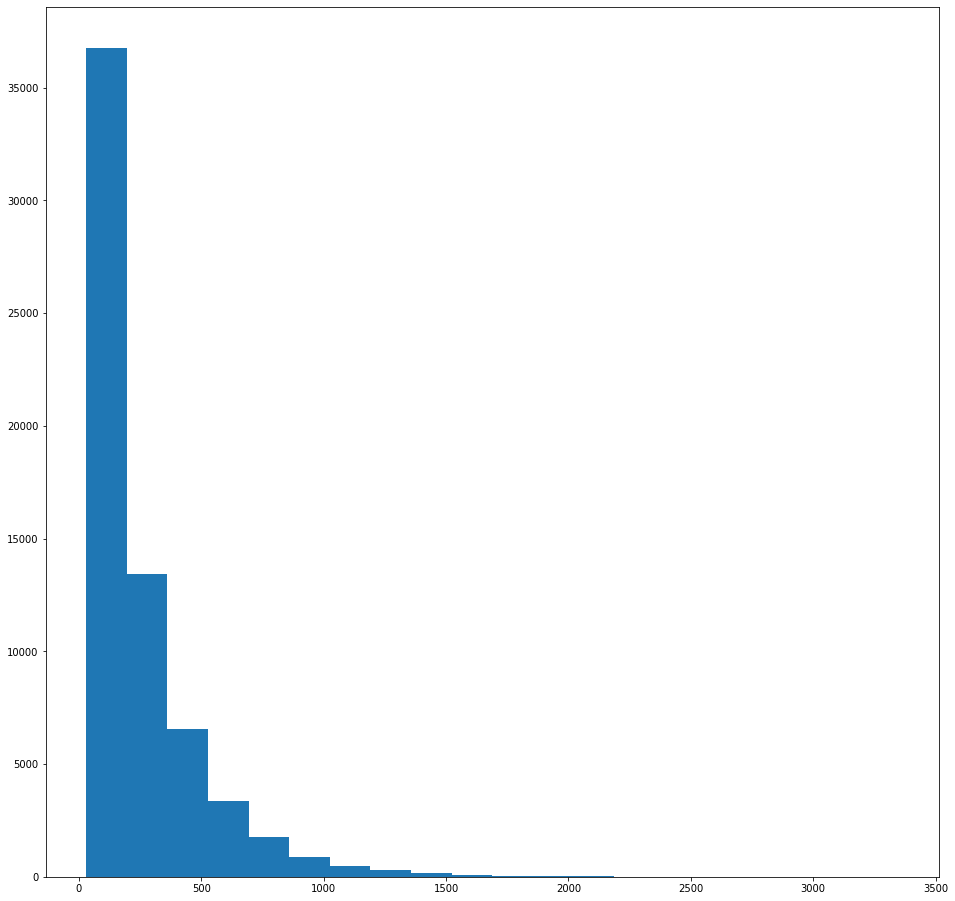

In [13]:
#num_features = df.select_dtypes(include=['float64', 'int64'])
df['history'].hist(figsize=(16,16), bins=20, grid=False);

In [14]:
#добавим новый признак, присвоим единичку клиентам с крупной суммой покупок, более 1500
df.loc[df['history'] >= 1500, 'history_new'] = 1
df.loc[df['history'] < 1500, 'history_new'] = 0

In [15]:
df['history_new'].value_counts()

0.0    63754
1.0      246
Name: history_new, dtype: int64

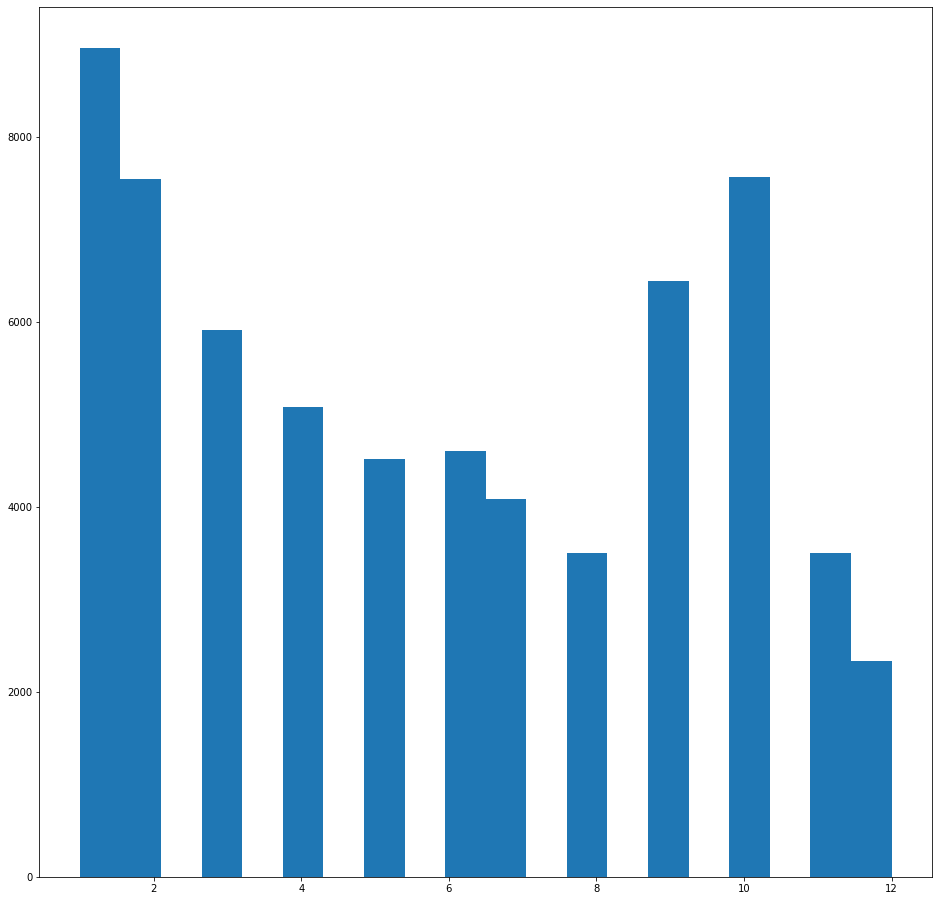

In [16]:
df['recency'].hist(figsize=(16,16), bins=20, grid=False);

In [17]:
#создадим группы по времени последнего заказа, у часто заказывающих будет 2, редко - 12, середина - 5
df.loc[df['recency'] <= 12, 'recency_new'] = 12
df.loc[df['recency'] <= 10, 'recency_new'] = 5
df.loc[df['recency'] <= 2, 'recency_new'] = 2

In [18]:
df['recency_new'].value_counts()

5.0     41675
2.0     16489
12.0     5836
Name: recency_new, dtype: int64

In [19]:
# dummies
df = pd.get_dummies(df, columns = ['zip_code', 'channel'])
df

,recency,history,used_discount,used_bogo,is_referral,treatment,target,history_new,recency_new,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,0,0.0,5.0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,0.0,5.0,1,0,0,0,0,1
2,7,180.65,0,1,1,1,0,0.0,5.0,0,1,0,0,0,1
3,9,675.83,1,0,1,1,0,0.0,5.0,1,0,0,0,0,1
4,2,45.34,1,0,0,1,0,0.0,2.0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,0,1,0,0.0,5.0,0,0,1,0,0,1
63996,5,38.91,0,1,1,1,0,0.0,5.0,0,0,1,0,1,0
63997,6,29.99,1,0,1,1,0,0.0,5.0,0,0,1,0,1,0
63998,1,552.94,1,0,1,1,0,0.0,2.0,0,1,0,1,0,0


In [20]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,treatment,target,history_new,recency_new,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.667094,0.146781,0.003844,4.865391,0.149422,0.449625,0.400953,0.121281,0.437828,0.440891
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.471257,0.353890,0.061879,2.601719,0.356507,0.497460,0.490095,0.326456,0.496123,0.496498
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,5.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
indices_train, indices_test = train_test_split(df.index, test_size=0.3, random_state=15)

In [22]:
X_train = df.loc[indices_train, :]
y_train = df.loc[indices_train, 'target']
treat_train = df.loc[indices_train, 'treatment']

X_test = df.loc[indices_test, :]
y_test = df.loc[indices_test, 'target']
treat_test=  df.loc[indices_test, 'treatment']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
    'uplift@30%': []
    }

In [23]:
X_train.groupby("treatment")['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,14991.0,0.105797,0.307588,0.0,0.0,0.0,0.0,1.0
1,29809.0,0.165957,0.372048,0.0,0.0,0.0,0.0,1.0


### 1. Подходы с одной моделью
#### 1.1 Одна модель с признаком коммуникации

In [ ]:
 #!pip install scikit-uplift==0.2.0

In [ ]:
#!pip install CatBoost

In [27]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)
uplift_sm

array([-4.93698568e-05, -1.44418487e-05, -1.33203606e-05, ...,
       -8.68264703e-06, -7.04513836e-05, -9.33705248e-06])

In [28]:
sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_10

0.0

In [29]:
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
sm_score_20

0.31265156689405726

In [30]:
sm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)
sm_score_30

0.20841330490102195

In [31]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)
models_results['uplift@30%'].append(sm_score_30)

#### 1.2 Трансформация классов
Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году. Метод заключается в прогнозировании немного измененного таргета:

In [39]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=40, thread_count=52, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)
ct_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)
models_results['uplift@30%'].append(ct_score_30)

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


#### 2.1 Две независимые модели
Как понятно из названия, подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

In [33]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)
tm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)
models_results['uplift@30%'].append(tm_score_30)

Посмотрим на результаты

In [34]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%,uplift@30%
1,ClassTransformation,1.000000,0.847885,0.565330
0,SoloModel,0.000000,0.312652,0.208413
2,TwoModels,-0.006444,0.313134,0.208735


#### Вариант с деревом решений

In [ ]:
#!pip install causalml

In [36]:
df

,recency,history,used_discount,used_bogo,is_referral,treatment,target,history_new,recency_new,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,0,0.0,5.0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,0.0,5.0,1,0,0,0,0,1
2,7,180.65,0,1,1,1,0,0.0,5.0,0,1,0,0,0,1
3,9,675.83,1,0,1,1,0,0.0,5.0,1,0,0,0,0,1
4,2,45.34,1,0,0,1,0,0.0,2.0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,0,1,0,0.0,5.0,0,0,1,0,0,1
63996,5,38.91,0,1,1,1,0,0.0,5.0,0,0,1,0,1,0
63997,6,29.99,1,0,1,1,0,0.0,5.0,0,0,1,0,1,0
63998,1,552.94,1,0,1,1,0,0.0,2.0,0,1,0,1,0,0


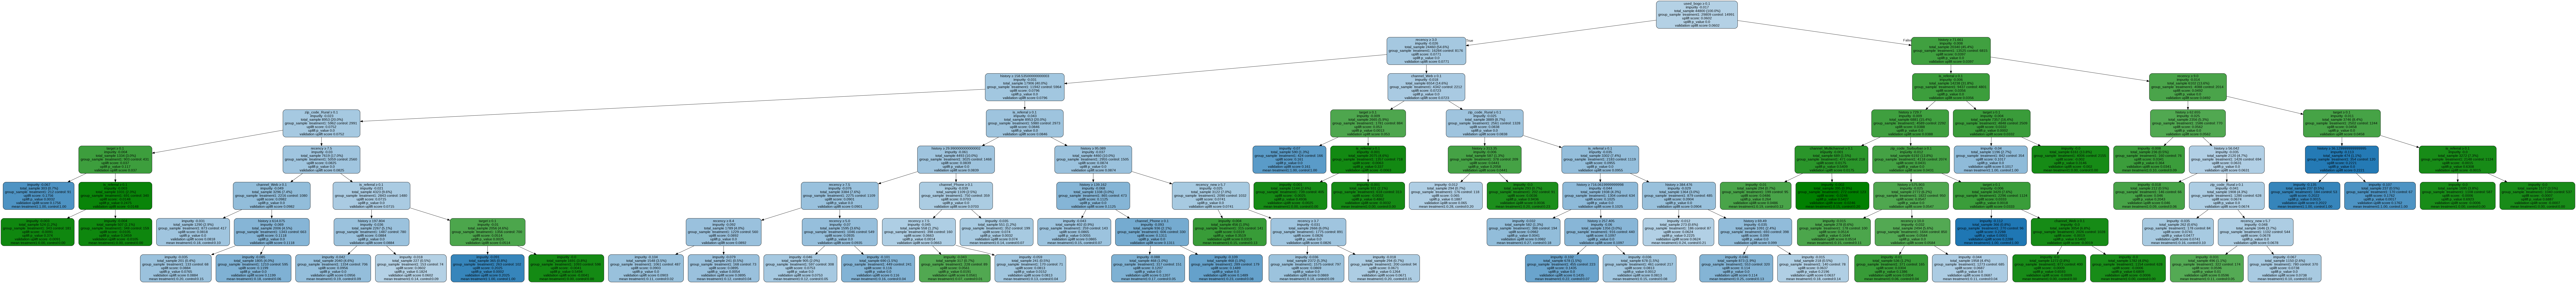

In [38]:
#%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

features = [col for col in df]
uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

In [128]:
# !git clone https://github.com/ub8er/causalml.git
# %cd causalml
# !pip install -r requirements.txt
# !python setup.py build_ext --inplace
# !python setup.py install